<a href="https://colab.research.google.com/github/akshaypt7/amazon_sales_prediction/blob/main/project_01_04_Using_entity_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 29.4 MB/s 
     |████████████████████████████████| 188 kB 65.1 MB/s 
     |████████████████████████████████| 1.2 MB 69.3 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 2.6 MB/s 
     |████████████████████████████████| 51 kB 305 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
# from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
# from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers import Dense, Flatten, Dropout, Input, Embedding, Reshape
from keras.layers import concatenate
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pickle
import csv
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

from sklearn.model_selection import train_test_split
import math
import pandas as pd

In [4]:
infile = open('/content/gdrive/MyDrive/bluebook/df_main.pkl','rb')
df_main = pickle.load(infile)

In [5]:
df_main = add_datepart(df_main,'date')

In [6]:
cat = ['Asin',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'hour','Month','Week', 'Day','Dayofweek','Dayofyear']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [8]:
enc = OrdinalEncoder()
enc.fit(df_main[cat])
df_main[cat]= enc.transform(df_main[cat])

In [9]:
condition = (df_main.Year < 2020) | (df_main.Month < 8)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

In [51]:
splits = (list(train_idx),list(valid_idx))

In [70]:
len(train_idx), len(valid_idx)

(8423, 2523)

In [10]:
X =df_main.drop(['Quantity'],axis=1)

In [ ]:
# X_train = df_main.drop(['Quantity'],axis=1).iloc[train_idx]
# y_train = df_main['Quantity'].iloc[train_idx]

# X_valid = df_main.drop(['Quantity'],axis=1).iloc[valid_idx]
# y_valid = df_main['Quantity'].iloc[valid_idx]

In [11]:
saved_embeddings_fname = '/content/gdrive/MyDrive/bluebook/embeddings.pickle'

In [ ]:
X.columns

Index(['Asin', 'Item Promo Discount', 'price', 'hour', 'Invoice Amount',
       'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

##### Explaining the function.



In the below function, the index_embedding_mapping is used to replace the categorical columns of X, using the embedding we created earlier. 

Now the mapping will change (that is the content in the dictionary) we have to compare that with the order in the embeddings we created. 

Which is [input_asin, input_hour, input_dayofweek, input_month, input_day, input_week ]

Now the keys of the dictionary should be the position of the embedding in the X.
For example the 2nd item in the dictionary is Hour, so we have to see which position is hour in X, and that position will be the key.

Like this we replace the categorical values for all categorical variables, and the continous columns are left unchanged.

Once we create the index_embedding_mapping, we next do a for loop, here you have to note, this X is not a dataframe, we are passing X.values into the function.

so each record in a row, now the second for loop comes which again helps us to go deeper, here i is the index of the column and feat is the values of each column index. 

Now if the index, i is in the index_embedding_mapping.keys we replace the entire value with the value of embedding if not we make it unchanged.

In [12]:
def embed_features(X, saved_embeddings_fname):
    f_embeddings = open(saved_embeddings_fname, "rb")
    embeddings = pickle.load(f_embeddings)

    index_embedding_mapping = {0: 0, 3: 1, 9: 2, 6: 3, 8: 4, 7: 5}
    X_embedded = []

    (num_records, num_features) = X.shape
    for record in X: 
        embedded_features = []
        for i, feat in enumerate(record):
            feat = int(feat)
            if i not in index_embedding_mapping.keys():
                embedded_features += [feat]
            else:
                embedding_index = index_embedding_mapping[i]
                embedded_features += embeddings[embedding_index][feat].tolist()

        X_embedded.append(embedded_features)

    return np.array(X_embedded)

In [13]:
X_emb = embed_features(X.values,saved_embeddings_fname)

### Add the embeddings into the Models and check their MAE

#### Creating training and validation set

This works - result_list = list(itemgetter(*index_list)(test_list)) , we need to make X_train and y_train in the form of list

In [ ]:
X_train = list(itemgetter(*train_idx)(X_emb)) 
X_valid = list(itemgetter(*valid_idx)(X_emb)) 

# or we can use list comprehension too for ex, test = [X_emb[i] for i in train_idx ]

In [ ]:

y_train = df_main['Quantity'].iloc[train_idx]

y_valid = df_main['Quantity'].iloc[valid_idx]

Note : We have created the train and test set from the X_embeddings. since X_embeddings is a list we use either list comprehension or list(itemgetter)

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
# This functions helps to convert the value into integ
def pred(y_pred,thres= 0.5):
  new_pred = np.where((y_pred-int(y_pred)) < thres,int(y_pred), int(y_pred)+1)
  return new_pred

In [ ]:
new_pred = np.vectorize(pred) # So that the function will accept list of integers.

#### Model 1- Random Forest

In [ ]:
def rf(xs, y, n_estimators=40,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
         max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
rf =rf(X_train,y_train)

In [ ]:
mae(y_valid,rf.predict(X_valid))

0.021638241267109636

**Our model with Embedding performed better than the model without it.**

Random Forest with Embedding = 0.0216

Random Forest without Embedding = 0.0280

In [ ]:
mae(y_valid,(new_pred(rf.predict(X_valid),0.42))) # predicting the accuracy by changing the threshold

0.005152596115735236

**Our Model using Embeddings performed better than the previous models**

### Neural Network with Embedding

In [18]:
f_embeddings = open(saved_embeddings_fname, "rb")
embeddings = pickle.load(f_embeddings)

In [28]:
df = pd.DataFrame(X_emb)

In [81]:
df_main.reset_index(inplace=True)

In [82]:
df_main.drop(['index'], axis =1, inplace=True)

In [83]:
df['Quantity'] = df_main['Quantity']

In [30]:
df.shape

(10946, 47)

In [34]:
cont, cat = cont_cat_split(df, max_card=900)

In [35]:
procs = [Categorify,FillMissing, Normalize]

In [50]:
df.shape

(10946, 48)

In [52]:
to_nn = TabularPandas(df,procs= procs, cont_names= cont, cat_names= cat, y_names= 'Quantity', splits =splits)

In [84]:
dls = to_nn.dataloaders(64)

In [65]:
dls.one_batch()[2].shape

torch.Size([528, 1])

In [71]:
dls.valid.xs.shape

(2523, 47)

In [85]:
learner_nn = tabular_learner(dls, y_range=(0,42), layers=[500,250],n_out=1, loss_func=F.mse_loss, metrics= torch.nn.L1Loss )

SuggestedLRs(valley=0.00363078061491251)

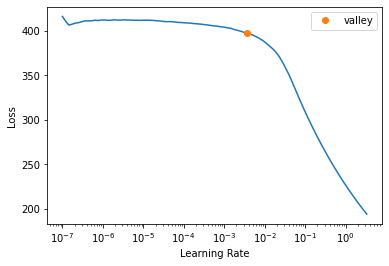

In [86]:
learner_nn.lr_find()

In [93]:
learner_nn = tabular_learner(dls, y_range=(0,42), layers=[500,250],n_out=1, loss_func=F.mse_loss, metrics= torch.nn.L1Loss )
learner_nn.fit_one_cycle(7,lr_max=1e-3)

epoch,train_loss,valid_loss,None,time
0,345.049805,317.459900,17.350271,00:01
1,64.082642,14.473331,1.669761,00:01
2,7.298007,12.177769,0.939022,00:01
3,1.969537,11.776754,0.727522,00:01
4,0.805031,0.416644,0.466517,00:01
5,0.321921,0.495924,0.539164,00:01
6,0.212124,0.426709,0.486565,00:01


In [90]:
learner_nn = tabular_learner(dls, y_range=(0,42), layers=[500,250],n_out=1, loss_func=F.mse_loss, metrics= torch.nn.L1Loss )
learner_nn.fit_one_cycle(7,lr_max=1e-3,wd=0.1)

epoch,train_loss,valid_loss,None,time
0,350.405060,210.911026,13.892867,00:01
1,64.316002,4.290181,1.724079,00:01
2,5.979640,0.600164,0.495257,00:01
3,0.821564,0.449848,0.503147,00:01
4,0.253618,0.425819,0.479580,00:01
5,0.177444,0.384029,0.459301,00:01
6,0.135783,0.377105,0.451703,00:01


refer - https://stackoverflow.com/questions/25431850/passing-a-list-of-indices-to-another-list-in-python-correct-syntax

### Creating our own model

In [ ]:
f_embeddings = open(saved_embeddings_fname, "rb")
embeddings = pickle.load(f_embeddings)

In [ ]:
dset = list(zip(X_train,y_train))
x,y = dset[0]
x.shape

(47,)

In [ ]:
valid_dset = list(zip(X_valid,y_valid))

In [ ]:
dset = list(zip(tensor(X_train).float(),tensor(y_train).float())) # now
valid_dset = list(zip(tensor(X_valid).float(),tensor(y_valid).float())) # now

In [ ]:
train_dl = DataLoader(dset,bs=128,shuffle=False)
valid_dl = DataLoader(valid_dset, bs=128, shuffle=False)

In [ ]:
dls= DataLoaders(train_dl,valid_dl) # now
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([128, 47]), torch.Size([128]))

In [ ]:
class model(Module):
  def __init__(self, no_emb,n_act=20):
    self.layers = nn.Sequential(
        
        nn.Linear(no_emb,n_act),
        nn.ReLU(),
        # nn.Linear(n_act,100),
        # nn.ReLU(),
        nn.Linear(n_act,1)
    )

        

  def forward(self,x):
    x = self.layers(x)  
    return x

In [ ]:
model = model(47) # 47 is the embedding size

In [ ]:
learn = Learner( dls, model,
                   loss_func=F.mse_loss, metrics= torch.nn.L1Loss)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,None,time
0,1162380416.000000,477888608.000000,21860.464844,00:00
1,288144704.000000,158149760.000000,12575.568359,00:00
2,9205341184.000000,25893945344.000000,160914.890625,00:00
3,12249784320.000000,357415808.000000,18905.228516,00:00
4,25530286080.000000,89434808.000000,9456.764648,00:00
5,6738661888.000000,655304192.000000,25598.689453,00:00
6,18157910016.000000,46143260.000000,6792.602539,00:00
7,4787015168.000000,8387.522461,82.174248,00:00
8,11566524416.000000,338279520.000000,18392.162109,00:00
9,3061414912.000000,63249.390625,245.160172,00:00


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:175: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss_grad = self.loss_func(self.pred, *self.yb)
/usr/local/lib/python3.7/dist-packages/fastai/learner.py:175: UserWarning: Using a target size (torch.Size([103])) that is different to the input size (torch.Size([103, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss_grad = self.loss_func(self.pred, *self.yb)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.r

### Conclusion

**Performance of the models with and without Embedding**

**MAE of Random Forest without EE = 0.02807**

**MAE of Random Forest with EE = 0.021209**

**MAE of Neural Network without EE = 0.186**

**MAE of Neural Network with EE = 0.451**


### Further work, 

- We can apply the same thing in neural network and boosting.
  - The problem with implementing in NN is that, after embedding our dataset is a list, we either have to convert that into a** dataframe** to use in fastai or we can create a new neural network using other method, where we pass in list in both cases.
  - Boosting is something we can try but which requires hyper parameter tuning, we can try one without that. Just to work with boosting.

- But it is better to work on this, maybe after we write a blog on this, it doesnt have to be super detailed in the sense that you have to feel any discomfort, we can work in pomodoro, maybe 1-3 pomodoros a day.
- Meanwhile we can work on creating dataloader and learner by ourself. the issue is we do not have much idea on how its done. Maybe we can do that when we learn more about the course like a dataloader or maybe in univ.ai 

- In between we also have to work on what we have learnt so far, maybe tomorrow. When we start writing the blog after few pomodoro maybe we can work on revision, we can have a look at the notebook questions we created. 